In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.options.display.max_rows=100
plt.figure(figsize(14,8));

<Figure size 1008x576 with 0 Axes>

# A

In [3]:
df = pd.read_csv('test_a.csv', names=['y'])

In [4]:
df.shape

(1263, 1)

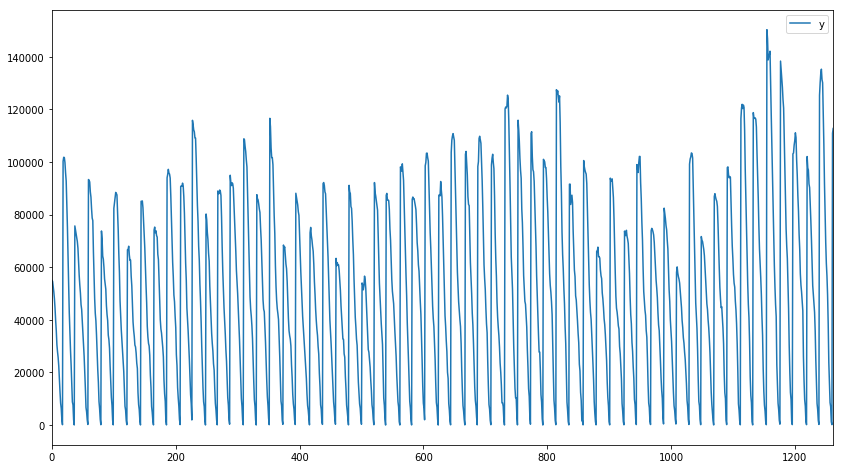

In [5]:
df.plot();

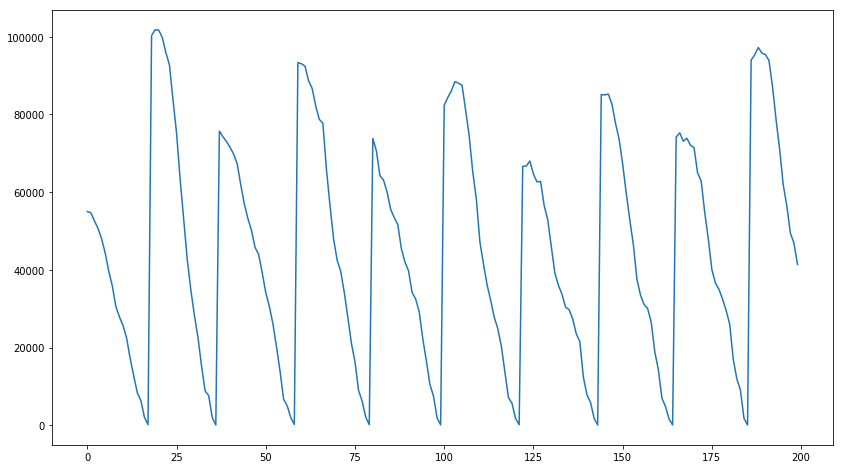

In [6]:
plt.plot(df.y.values[:200]);

In [7]:
#optimal AR(1)-model parameter value
def get_ar1_rho(data):
    data /= 10000
    rho_optim = 0
    n = data.shape[0]
    for i in range(2,n):
        rho_optim += data[i]*data[i-1]
    rho_optim /= sum(data[2:]**2)
    data *= 10000
    return rho_optim

In [8]:
#p-value<0.05 : stationary
sm.tsa.stattools.adfuller(df.y.values)[1]

0.0005191296794076842

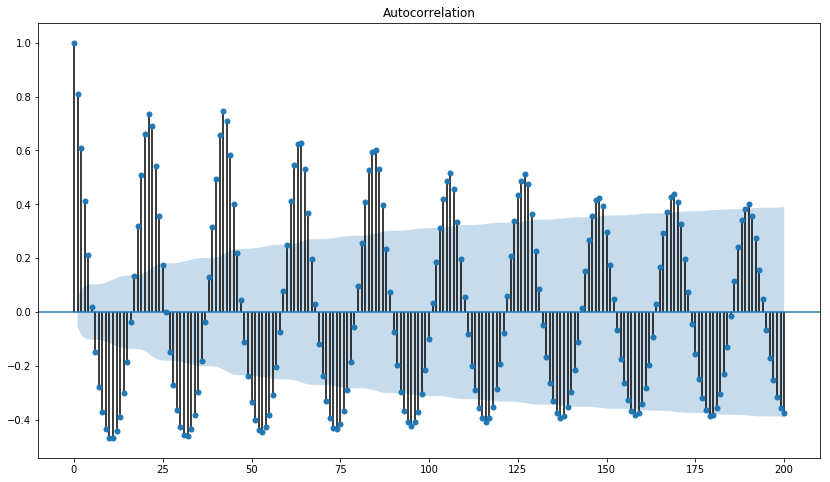

In [9]:
sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=200);

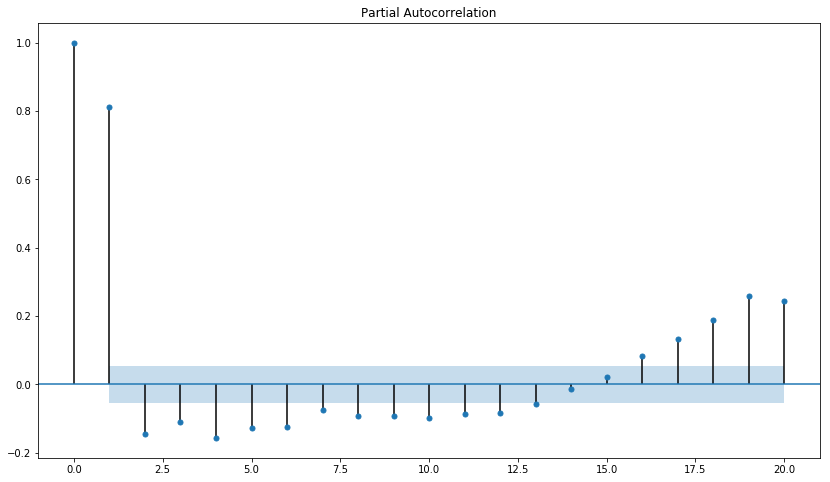

In [10]:
sm.graphics.tsa.plot_pacf(df, lags=20);

In [11]:
diff = df.diff(periods=1).dropna()

In [12]:
x = diff.values

In [13]:
ans = []
for idx in range(len(x)):
    if x[idx]>10000:
        ans.append(idx)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53a83ddd30>]],
      dtype=object)

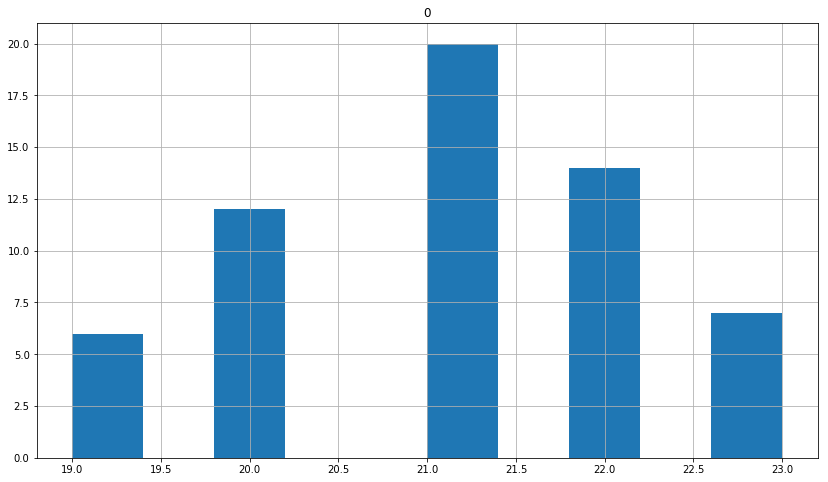

In [14]:
pd.DataFrame(data=ans).diff(1).hist()

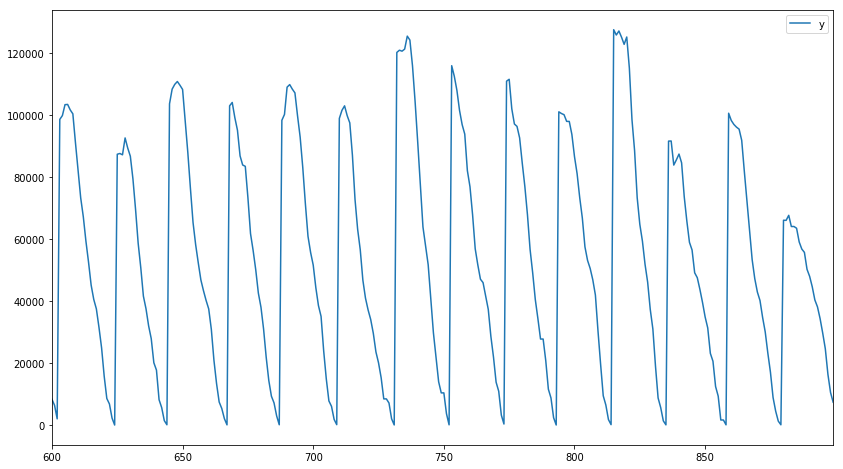

In [15]:
df[600:900].plot()

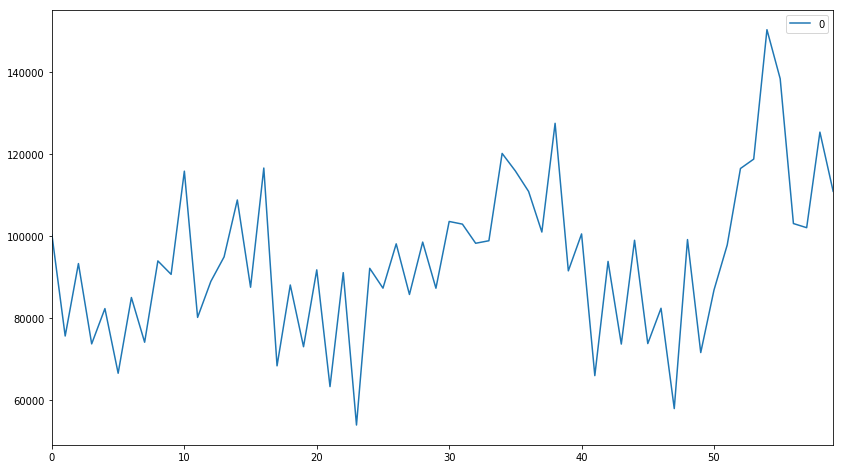

In [16]:
pd.DataFrame(data=df.values[np.array(ans)+1]).plot()

In [17]:
peaks = df.y.values[np.array(ans)+1]

In [18]:
#stationary
sm.tsa.stattools.adfuller(peaks)[1]

0.009311273126538852

In [19]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(peaks, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(3, 1, 3); AIC=1344.458, BIC=1361.078, Fit time=0.251 seconds
Fit ARIMA: order=(0, 1, 0); AIC=1349.750, BIC=1353.905, Fit time=0.003 seconds
Fit ARIMA: order=(1, 1, 0); AIC=1314.898, BIC=1321.130, Fit time=0.066 seconds
Fit ARIMA: order=(0, 1, 1); AIC=1325.561, BIC=1331.794, Fit time=0.051 seconds
Fit ARIMA: order=(2, 1, 0); AIC=1316.016, BIC=1324.326, Fit time=0.095 seconds
Fit ARIMA: order=(1, 1, 1); AIC=1353.822, BIC=1362.132, Fit time=0.132 seconds
Fit ARIMA: order=(2, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.684 seconds


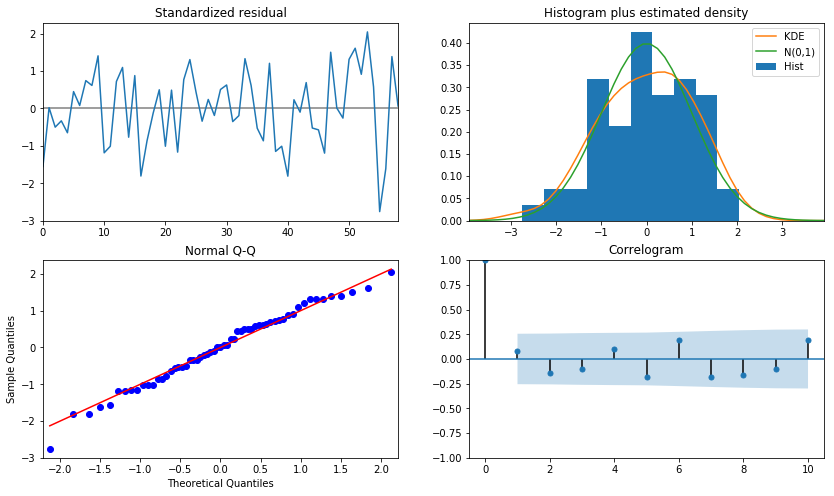

In [20]:
model.plot_diagnostics();

In [21]:
from itertools import product

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

ps = range(0, 5)
qs = range(0, 3)
Ps = range(0, 2)
Qs = range(0, 2)
d=1
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(peaks, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2min 13s, sys: 1min, total: 3min 14s
Wall time: 13.1 s


In [23]:
prediction = best_model.fittedvalues

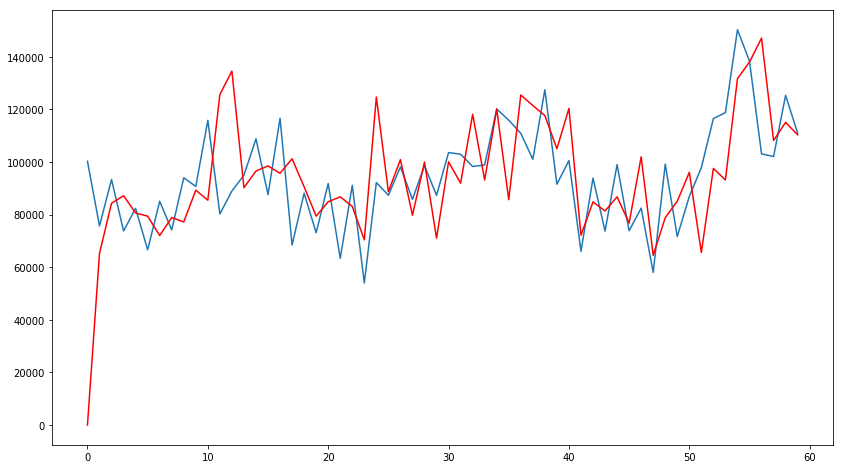

In [24]:
plt.plot(peaks)
plt.plot(prediction, color='red');

In [25]:
prediction = best_model.fittedvalues

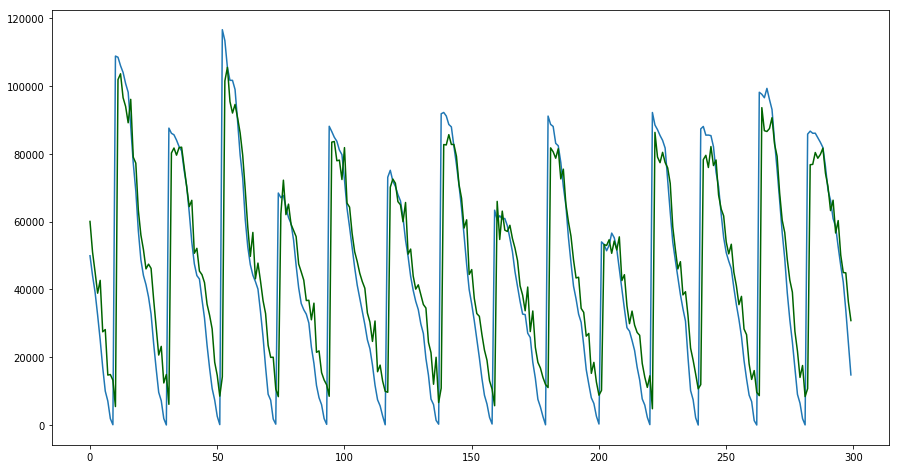

In [41]:
plt.plot(df.y.values[300:600])
plt.plot(prediction[300:600], color='darkgreen')

<Figure size 1080x504 with 0 Axes>

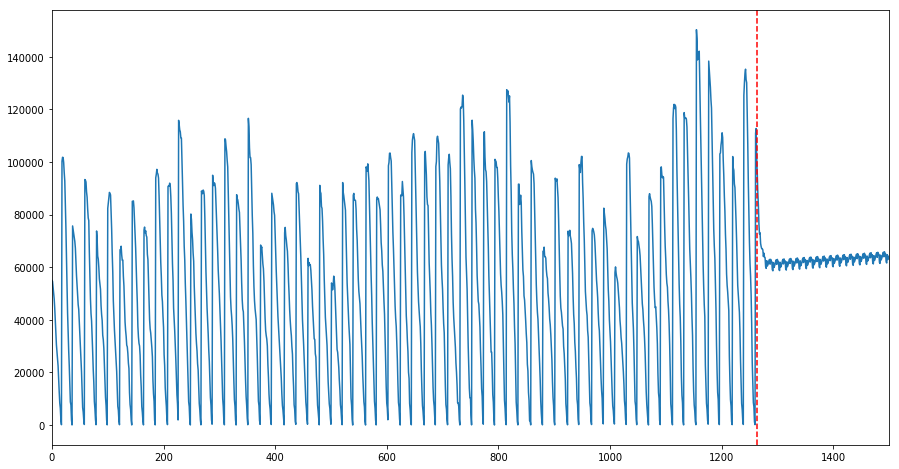

<Figure size 1080x504 with 0 Axes>

In [42]:
peaks = df.y.values
frcst = best_model.predict(start=1263, end=1500)
peaks = np.append(peaks, frcst)
df2 = pd.DataFrame(peaks, columns=['y'])

ax = df2.y.plot()
ax.axvline(1263, color="red", linestyle="--")
plt.figure(figsize(15,7))

<Figure size 1080x504 with 0 Axes>

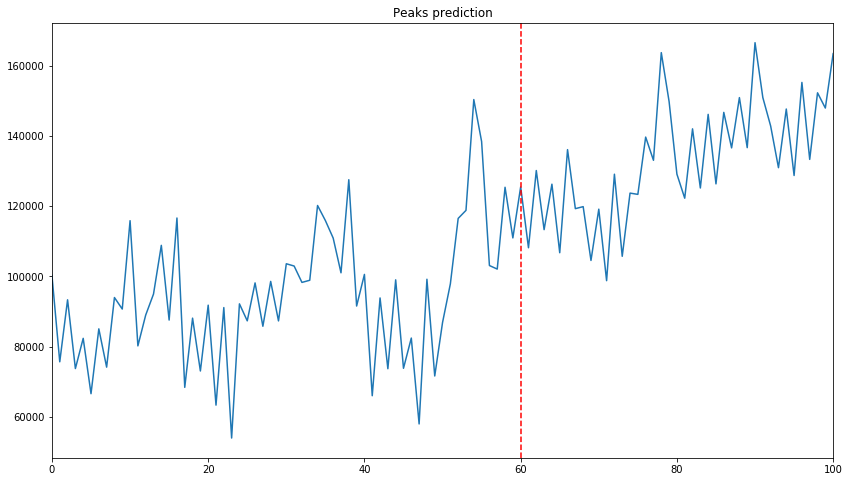

<Figure size 1080x504 with 0 Axes>

In [26]:
peaks = df.y.values[np.array(ans)+1]
frcst = best_model.predict(start=60, end=100)
peaks = np.append(peaks, frcst)
df2 = pd.DataFrame(peaks, columns=['y'])

ax = df2.y.plot(title='Peaks prediction')
ax.axvline(60, color="red", linestyle="--")
plt.figure(figsize(15,7))
#df2.y.plot();

# B

In [27]:
df = pd.read_csv('test_b.csv', sep=';')
df['A-B'] = df.A-df.B
df['E-F'] = df.E-df.F
df['G-H'] = df.G-df.H
df['I-J'] = df.I-df.J

In [28]:
np.corrcoef(df.A, df.B)[0, 1]

0.9926543474886318

In [29]:
df.head(20)

,A,B,C,D,E,F,G,H,I,J,A-B,E-F,G-H,I-J
0,6993,6694,0,0,12405,12408,12,14,406,403,299,-3,-2,3
1,75289,75441,0,0,12354,12361,1,19,504,469,-152,-7,-18,35
2,14077,10393,0,0,12401,12398,12,47,270,223,3684,3,-35,47
3,7157,4912,0,0,12412,12381,18,55,262,232,2245,31,-37,30
4,10314,10550,0,0,12400,12403,12,49,270,273,-236,-3,-37,-3
5,4412,4305,0,0,12359,12364,1,36,238,237,107,-5,-35,1
6,147883,147318,0,0,12273,12276,30,36,274,273,565,-3,-6,1
7,912,1005,0,0,12312,12315,13,61,372,384,-93,-3,-48,-12
8,3371,3545,0,0,12312,12315,13,54,369,378,-174,-3,-41,-9
9,347,277,0,0,12359,12364,1,31,285,273,70,-5,-30,12


# C

In [30]:
mu = [1, 2, 3]
sd = [3, 2, 1]
rho = [-0.5, 0.0, 0.5]
covariance_matrix = [
    [9.0, -3, 0.0],
    [-3.0, 4.0, 1.0],
    [0.0, 1.0, 1.0]
]

In [31]:
x1, x2, x3 = np.random.multivariate_normal(mu, covariance_matrix, 10000000).T

In [32]:
def expected_value(f, args_list):
    ans = 0
    n = len(args_list)
    for args in args_list:
        ans += f(args)/n
    return ans

In [33]:
expected_value(max, np.array([x1, x2, x3]).T)

3.8001766126326113

# Summary

## Task A

* Series has "jumps" every 20-22 step.
* AR(1)/AutoARIMA/SARIMA/Prophet doesn't work well because of specific structure of the series (it is stationary but models implicitly based on rolling means are not OK with such sharp "jumps").
* 1. So we predict peaks with ARIMA((2, 1, 0), (1, 1, 0)).
  2. Build a prediction for recessions (relaxations) using any heuristic (statistical or simply building a line between bottom and peak with constant periods (21))

## Task B

* It is clear that there is no function $f$ such as $A = f(B, C, D...)$ because there are $A_i$ and $A_j$ with the same arguments. Maybe it is real to find some $g$ such as $A-B=f(C, D...)$.
* A sign of $(A-B)$ equals to a sign of $(E-F)(G-H)(I-J)$ almost in all the cases.
* Simple regression model doesn't help to find precise solution. Also there is no sense to build RF/GB models because there is already 0.99 correlation coefficient so we are only interested in precise solutions like $A-B=f(C, D...)$.

## Task C

* $E[F]=E[\max(x_1, x_2, x_3)]=3.8$
* $\frac{\partial^2 f}{\partial \mu^2} = 0$
* $\frac{\partial f}{\partial \rho_{12}} = ?$

Ideas about the last subtask:

*Parametrization trick*: $X=mu+\Sigma^{1/2}\epsilon$. The problem is to find $\Sigma^{1/2}$:

Assume we want to find derivative with respect to $\rho_{12}$.
$$\Sigma = \begin{pmatrix}
  9& -3\rho_{12} & 0 \\
  -3\rho_{12} &4 &1\\
  0 &1 &1
\end{pmatrix}$$.
As $\Sigma$ is positive definite we should find spectral decomposition of $\Sigma$ and then $\Sigma^{1/2}=S\Lambda^{1/2}S^{-1}$. In general case it can be difficult but maybe it occurs that $\lambda=\alpha+\beta \rho_{12}$.
If $\Sigma^{1/2}$ is known it is easy to find derivative of $\max(\mu_1+\Sigma^{1/2}\epsilon_1,\mu_2+\Sigma^{1/2}\epsilon_2,\mu_3+\Sigma^{1/2}\epsilon_3)$.

Unfortunately it's not clear how to apply autograd for such function.